# REDES NUERONALES RECURRENTES

Implementacion con un set de sañales trigonometricas.

## Funciones comunes a todas la partes

In [1]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

In [2]:
# Funcion para generar base de datos de señales
def generate_time_series(batch_size, n_steps, n_future):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
# función que plotea un array de curvas (inputs y outputs)
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()



In [4]:
# Clase dataset para luego armar los dataloader
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix]) # si no es train, solo devuelve el X


In [94]:
# funciones de entrenamiento

from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            #print(X.shape)
            #input()
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)

            #print('y shape')
            #print(y.shape)
            y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad
            #print(y.shape)
            #print(' y hat shape')
            #print(y_hat.shape)
            
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")
        
        bar = tqdm(dataloader['eval'])
        model.eval()
        
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [6]:
# función para imprimir parametros del modelo.
def imp_param(model):
  print('-'*84)
  print('PARAMETROS DEL MODELO')
  print('-'*84)
  for name, param in model.named_parameters():
    if param.requires_grad: 
      print('Nombre del parámetro: ')
      print(name)
      print('Tamaño del parámetro: ')
      print(param.data.shape)
      print()

## Primera aproximación de recurrencia, empleado un perceptrón multicapa.
(adapación de un MLP para predecir el valor futuro de un señal)



In [7]:
n_steps = 50
n_future = 1
series = generate_time_series(10000, n_steps, n_future)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

X and y Train shape
(7000, 50, 1) (7000, 1, 1)
X and y Valid shape
(2000, 50, 1) (2000, 1, 1)
X and y Test shape
(1000, 50, 1) (1000, 1, 1)


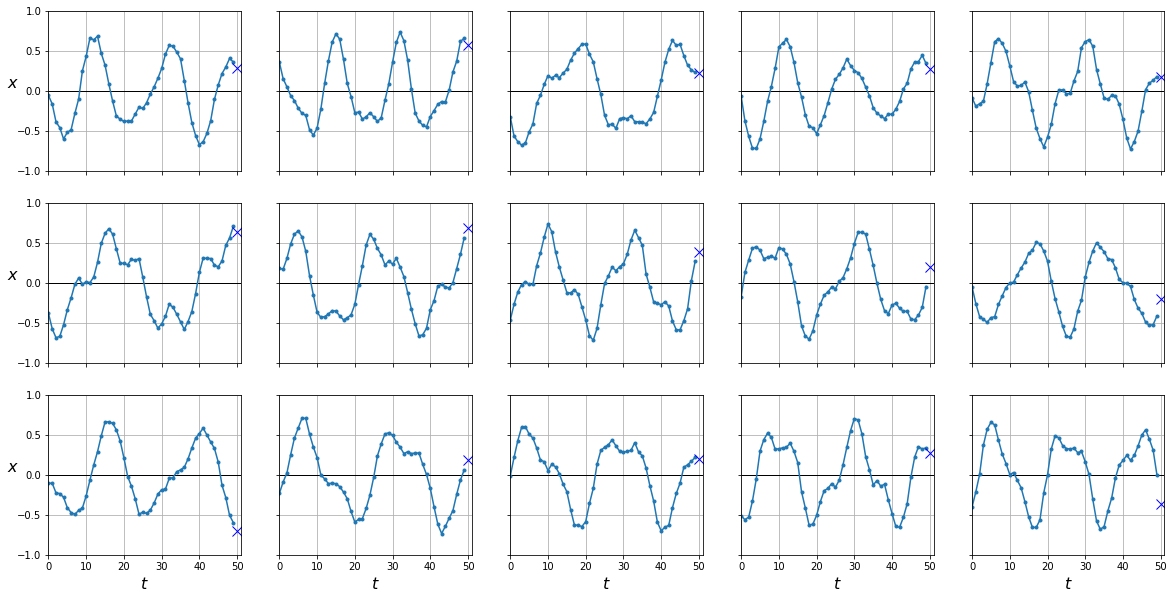

In [8]:
plot_series(X_test, y_test)

In [9]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

MLP para comparar luego con RNN

In [10]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=n_steps, n_out=n_future):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

# n_steps y out_future definidos arriba
mlp = MLP(n_steps, n_future)
mlp

MLP(
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [11]:
fit(mlp, dataloader)

epoch numero:  0


valid_loss 0.05210: 100%|██████████| 32/32 [00:00<00:00, 81.21it/s]


epoch numero:  1


valid_loss 0.03389: 100%|██████████| 32/32 [00:00<00:00, 85.52it/s]


epoch numero:  2


valid_loss 0.02371: 100%|██████████| 32/32 [00:00<00:00, 97.63it/s] 


epoch numero:  3


valid_loss 0.01777: 100%|██████████| 32/32 [00:00<00:00, 95.88it/s] 


epoch numero:  4


valid_loss 0.01413: 100%|██████████| 32/32 [00:00<00:00, 83.94it/s]


epoch numero:  5


valid_loss 0.01191: 100%|██████████| 32/32 [00:00<00:00, 100.20it/s]


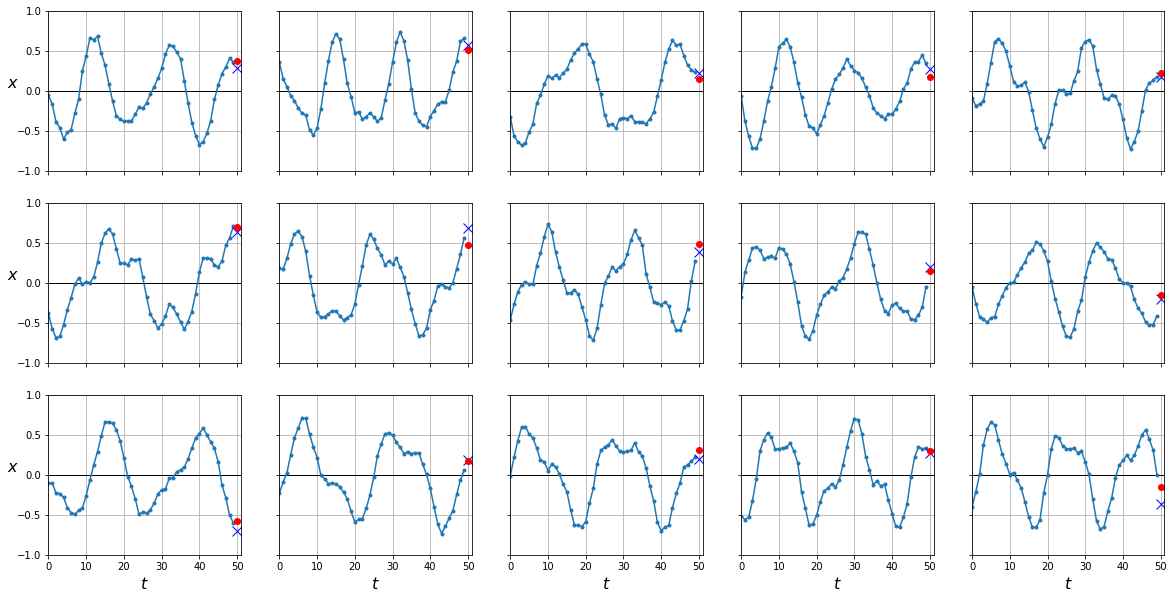

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.011999218

In [12]:
y_pred = predict(mlp, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred)

## Veamos ahora una RNN básica de 1 sola neurona

In [13]:
class SimpleRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=1, num_layers=1, batch_first=True)

  def forward(self, x):
    x, h = self.rnn(x) 
    # solo queremos la última salidas
    #return x[:,-10:]
    return x[:,-1:,-1]

rnn = SimpleRNN()
rnn

SimpleRNN(
  (rnn): RNN(1, 1, batch_first=True)
)

In [14]:
# veamos que arroja nuestra rnn

entrada = torch.rand(50)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.8228, 0.2019, 0.4559, 0.5184, 0.7765, 0.1867, 0.7186, 0.4362, 0.7053,
        0.9602, 0.4076, 0.4660, 0.3654, 0.9638, 0.5057, 0.7982, 0.2548, 0.4480,
        0.4556, 0.0248, 0.8904, 0.3460, 0.3997, 0.9620, 0.5833, 0.8294, 0.4606,
        0.7366, 0.1658, 0.3199, 0.8767, 0.6458, 0.2947, 0.3925, 0.7907, 0.7274,
        0.5177, 0.1584, 0.8431, 0.0676, 0.1745, 0.0081, 0.3320, 0.0854, 0.4819,
        0.1584, 0.2452, 0.7208, 0.6287, 0.1659])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 50, 1])

In [15]:
# paso la entrada a la red
salida = rnn(entrada)

print('salida de la red (largo igual al input):')
print(salida)

print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[0.2009]], grad_fn=<SelectBackward0>)
salida shape:
torch.Size([1, 1])


In [16]:
# ahora el vamos a pasar un set del dataset...

In [17]:

# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como input:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como input:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 1, 1])


In [18]:
nr = 0
serie = xs[nr]
deseado = ys[nr]
print('input shape:')
print(serie.shape)
salida = rnn(serie[None,:])
print('salida de la red (largo igual al input):')
print(salida.shape)
print('tamaño del valor deseado:')
print(deseado.shape)


input shape:
torch.Size([50, 1])
salida de la red (largo igual al input):
torch.Size([1, 1])
tamaño del valor deseado:
torch.Size([1, 1])


In [19]:
fit(rnn, dataloader)

epoch numero:  0


valid_loss 0.17286: 100%|██████████| 32/32 [00:00<00:00, 127.33it/s]


epoch numero:  1


valid_loss 0.14852: 100%|██████████| 32/32 [00:00<00:00, 160.81it/s]


epoch numero:  2


valid_loss 0.12790: 100%|██████████| 32/32 [00:00<00:00, 149.06it/s]


epoch numero:  3


valid_loss 0.10745: 100%|██████████| 32/32 [00:00<00:00, 142.03it/s]


epoch numero:  4


valid_loss 0.08653: 100%|██████████| 32/32 [00:00<00:00, 141.83it/s]


epoch numero:  5


valid_loss 0.06560: 100%|██████████| 32/32 [00:00<00:00, 130.61it/s]


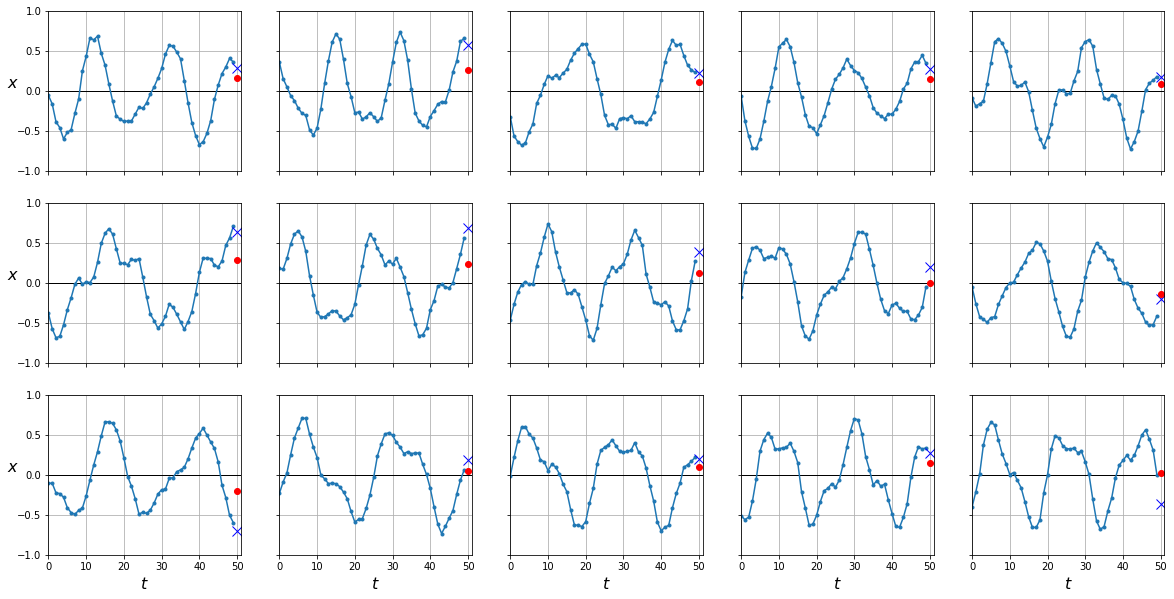

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.06285041

In [20]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

## Comparacion de parámetros entre MLP y RNN implementada

In [21]:
# parámetros en el MLP

imp_param(mlp)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 50])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])



In [22]:
# parámetros en el RNN

imp_param(rnn)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([1])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([1])



## Incorporamos más neuronas en la RNN

In [23]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    # get the last output and apply linear layer
    #print('x shape')
    #print(x.shape)
    #print('x shape [:,-1:]')
    #print(x[:,-1:].shape)
    y = self.fc(x[:,-1])
    
    return y

rnn_2 = RNN()

In [24]:
# parámetros en el RNN

imp_param(rnn_2)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 20])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])



In [25]:
# veamos que arroja nuestra rnn_2

entrada = torch.rand(20)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.4289, 0.1275, 0.5222, 0.3979, 0.4642, 0.5433, 0.3281, 0.4406, 0.7525,
        0.4775, 0.6200, 0.8353, 0.7283, 0.3325, 0.4574, 0.8260, 0.3621, 0.8905,
        0.8408, 0.9612])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 20, 1])

In [26]:
# paso la entrada a la red
salida = rnn_2(entrada)

print('salida de la red (largo igual al input):')
print(salida)
print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[0.0097]], grad_fn=<AddmmBackward0>)
salida shape:
torch.Size([1, 1])


In [27]:
fit(rnn_2, dataloader)

epoch numero:  0


valid_loss 0.01923: 100%|██████████| 32/32 [00:00<00:00, 123.43it/s]


epoch numero:  1


valid_loss 0.00881: 100%|██████████| 32/32 [00:00<00:00, 129.77it/s]


epoch numero:  2


valid_loss 0.00558: 100%|██████████| 32/32 [00:00<00:00, 123.77it/s]


epoch numero:  3


valid_loss 0.00459: 100%|██████████| 32/32 [00:00<00:00, 132.56it/s]


epoch numero:  4


valid_loss 0.00455: 100%|██████████| 32/32 [00:00<00:00, 137.78it/s]


epoch numero:  5


valid_loss 0.00429: 100%|██████████| 32/32 [00:00<00:00, 124.93it/s]


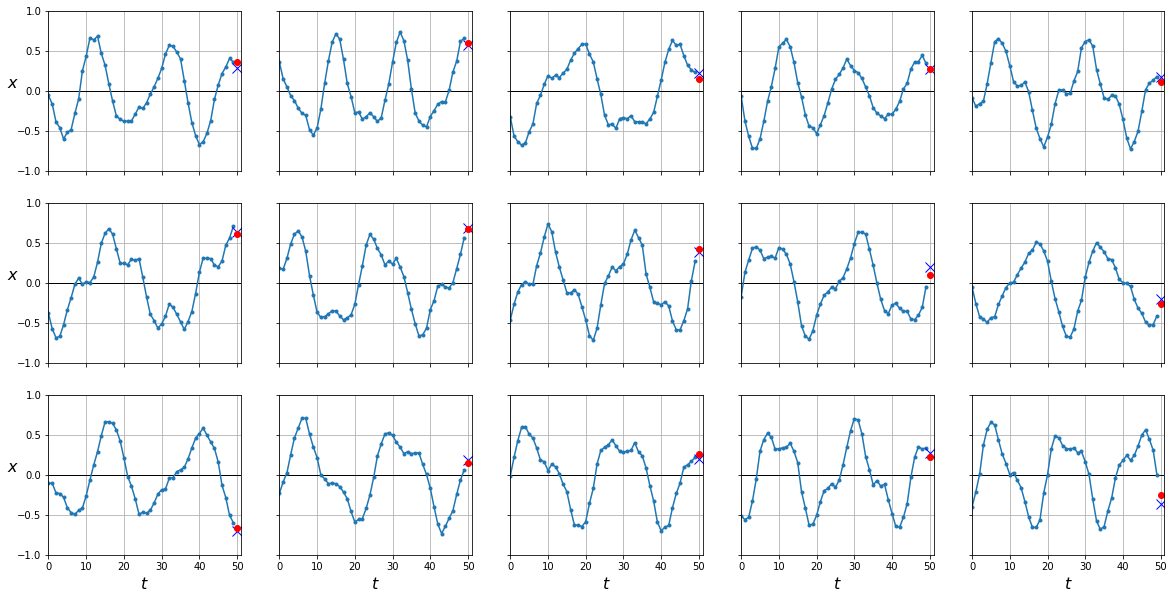

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.0043671215

In [28]:
y_pred = predict(rnn_2, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

## Le agregamos 1 layer mas, para tener mas profundidad





In [29]:
class DeepRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [30]:
rnn_deep = DeepRNN()
fit(rnn_deep, dataloader)

epoch numero:  0


valid_loss 0.01079: 100%|██████████| 32/32 [00:00<00:00, 112.15it/s]


epoch numero:  1


valid_loss 0.00503: 100%|██████████| 32/32 [00:00<00:00, 108.69it/s]


epoch numero:  2


valid_loss 0.00415: 100%|██████████| 32/32 [00:00<00:00, 118.51it/s]


epoch numero:  3


valid_loss 0.00388: 100%|██████████| 32/32 [00:00<00:00, 113.71it/s]


epoch numero:  4


valid_loss 0.00359: 100%|██████████| 32/32 [00:00<00:00, 115.20it/s]


epoch numero:  5


valid_loss 0.00364: 100%|██████████| 32/32 [00:00<00:00, 116.13it/s]


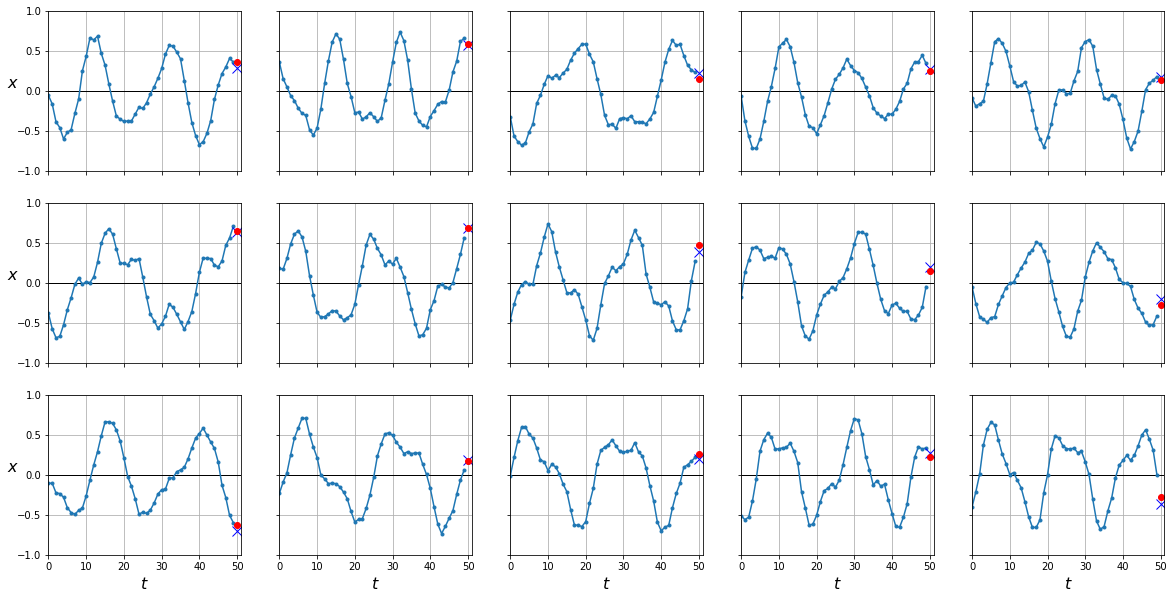

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.0038337817

In [31]:
y_pred = predict(rnn_deep, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

In [32]:
# parámetros en el RNN

imp_param(rnn_deep)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.weight_ih_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.weight_hh_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 20])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])



## predecimos 10 valores a futuro, colocando la última predicción en la entrada, hasta llegar a 10 pasos iterativos

series shape
(10000, 60, 1)
X and y Train shape
(7000, 50, 1) (7000, 10, 1)
X and y Valid shape
(2000, 50, 1) (2000, 10, 1)
X and y Test shape
(1000, 50, 1) (1000, 10, 1)


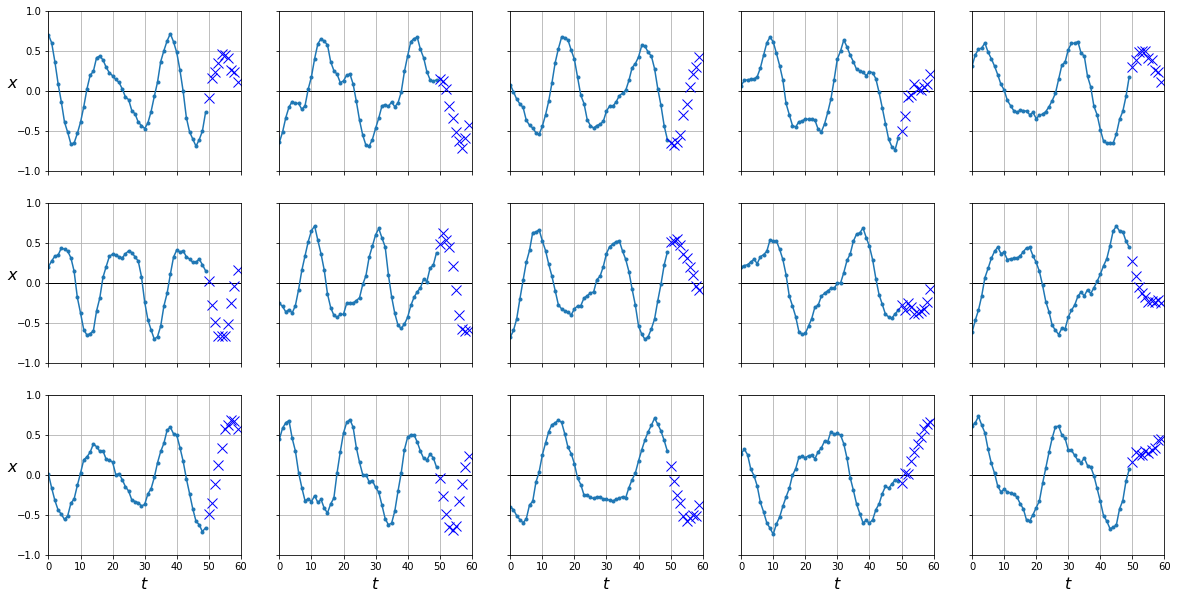

(1000, 10, 1)
(1000, 1, 1)


In [33]:
# generamos unos nuevos datos para tener con qué comparar

n_steps = 50
n_future = 10

series = generate_time_series(10000, n_steps, n_future)
print('series shape')
print(series.shape)

X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

# ploteamos
plot_series(X_test, y_test)
print(y_test.shape)
print(y_test[:,:1,:].shape)

In [34]:
#  tenemos q armar un nuevo dataloader que pase 1 solo valor a futuro
# pero tengamos los siguientes 9 para ver el error de nuestra propia iteración
dataset = {
    'train': TimeSeriesDataset(X_train, y_train[:,:1,:]),
    'eval': TimeSeriesDataset(X_valid, y_valid[:,:1,:]),
    'test': TimeSeriesDataset(X_test, y_test[:,:1,:], train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}
print(type(dataloader))


<class 'dict'>


In [35]:
# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como output:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como output:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 1, 1])


In [36]:
# entreno de nueva la ultima red y graficamos
rnn_deep = DeepRNN()
fit(rnn_deep, dataloader)


epoch numero:  0


valid_loss 0.00902: 100%|██████████| 32/32 [00:00<00:00, 119.96it/s]


epoch numero:  1


valid_loss 0.00579: 100%|██████████| 32/32 [00:00<00:00, 111.04it/s]


epoch numero:  2


valid_loss 0.00447: 100%|██████████| 32/32 [00:00<00:00, 113.23it/s]


epoch numero:  3


valid_loss 0.00386: 100%|██████████| 32/32 [00:00<00:00, 117.48it/s]


epoch numero:  4


valid_loss 0.00332: 100%|██████████| 32/32 [00:00<00:00, 113.20it/s]


epoch numero:  5


valid_loss 0.00326: 100%|██████████| 32/32 [00:00<00:00, 115.18it/s]


In [37]:
print(xs.shape)
#predict(rnn_deep, xs)
sal = rnn_deep(xs)
sal.shape

torch.Size([64, 50, 1])


torch.Size([64, 1])

(1000, 10)


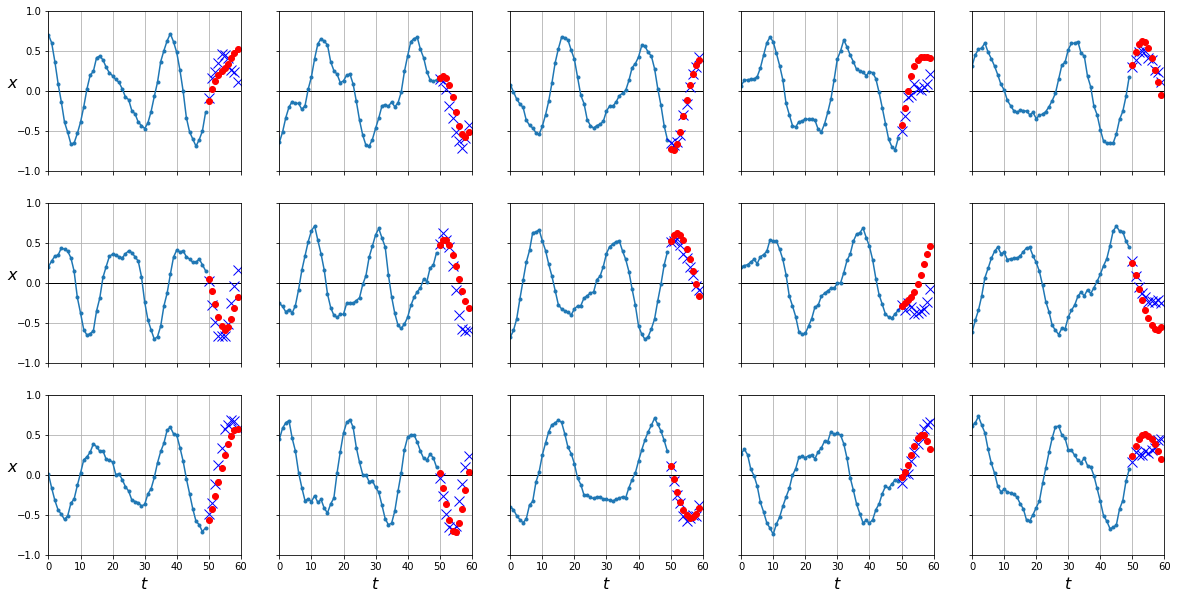

(1000, 10, 1)
(1000, 10)


0.038750507

In [38]:
# graficamos

X = X_test
for step_ahead in range(10):
    #print(step_ahead)
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0) # para el predict lea bien los datos (de este modo lee batch x largo x prof)
    #print(inputs.shape)
    y_pred_one = predict(rnn_deep, inputs).cpu().numpy()
    #print(y_pred_one.shape)
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)
    #print(X.shape)

y_pred = X[:, n_steps:, -1]
print(y_pred.shape)
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)

epoch numero:  0


valid_loss 0.00799: 100%|██████████| 32/32 [00:00<00:00, 277.59it/s]


epoch numero:  1


valid_loss 0.00574: 100%|██████████| 32/32 [00:00<00:00, 250.29it/s]


epoch numero:  2


valid_loss 0.00455: 100%|██████████| 32/32 [00:00<00:00, 201.86it/s]


epoch numero:  3


valid_loss 0.00391: 100%|██████████| 32/32 [00:00<00:00, 181.81it/s]


epoch numero:  4


valid_loss 0.00347: 100%|██████████| 32/32 [00:00<00:00, 229.34it/s]


epoch numero:  5


valid_loss 0.00326: 100%|██████████| 32/32 [00:00<00:00, 286.05it/s]


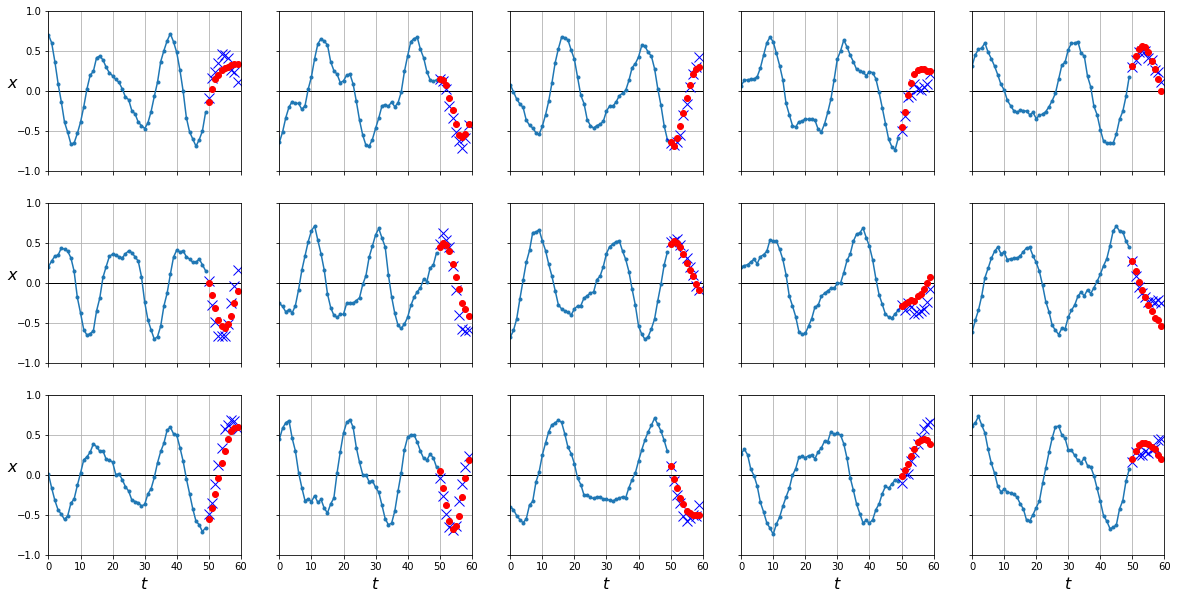

(1000, 10, 1)
(1000, 10)
MSE del modelo nlp:  0.018532824


In [39]:
# lo comparamos en el mlp
# entreno de nuevo el mlp con los nuevos datos y graficamos

fit(mlp, dataloader)

X = X_test
for step_ahead in range(10):
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0)  # para el predict lea bien los datos (de este modo lee batch x largo x prof)
    y_pred_one = predict(mlp, inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mse_mlp = mean_squared_error(np.squeeze(y_test), y_pred)
print("MSE del modelo nlp: ",mse_mlp)


## Crear una RNN que tenga 10 salidas y mejore el error del MLP usado antes. Asegurarse de compararlos con el mismo set datos!!

### Creamos la clase con 10 salidas y 2 RNNs conectadas mediante una fully connected

In [120]:
class RNN_10_outs_doble(torch.nn.Module):
  def __init__(self,hidden_size=30,num_layers=3):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc = torch.nn.Linear(hidden_size, 15)
    self.rnn2 = torch.nn.RNN(input_size=15, hidden_size=10, num_layers=num_layers, batch_first=True)
    
  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    x = torch.unsqueeze(x, 1)
    x, h = self.rnn2(x) 
    x = h[-1] 
    return x

### Generamos nuestro objeto con el modelo de red de 10 salidas

In [163]:
hidden_size_10_outs = 40
layers_10_outs = 4
rnn_10_outs_doble = RNN_10_outs_doble(hidden_size=hidden_size_10_outs,num_layers=layers_10_outs)

### Vemos los parametros del modelo

In [164]:
imp_param(rnn_10_outs_doble)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([40, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([40, 40])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([40])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([40])

Nombre del parámetro: 
rnn.weight_ih_l1
Tamaño del parámetro: 
torch.Size([40, 40])

Nombre del parámetro: 
rnn.weight_hh_l1
Tamaño del parámetro: 
torch.Size([40, 40])

Nombre del parámetro: 
rnn.bias_ih_l1
Tamaño del parámetro: 
torch.Size([40])

Nombre del parámetro: 
rnn.bias_hh_l1
Tamaño del parámetro: 
torch.Size([40])

Nombre del parámetro: 
rnn.weight_ih_l2
Tamaño del parámetro: 
torch.Size([40, 40])

Nombre del parámetro: 
rnn.weight_hh_l2
Tamaño del parámetro: 
torch

### Configuramos los dataset y dataloaders para que y tenga 10 valores en el fit por cada calculo del error (y_hat devuelve 10 valores)

In [165]:
dataset_10_outs = {
    'train': TimeSeriesDataset(X_train, y_train),#Y ya tiene dimension (num_muestras, 10, 1)
    'eval': TimeSeriesDataset(X_valid, y_valid),#Y ya tiene dimension (num_muestras, 10, 1)
    'test': TimeSeriesDataset(X_test, y_test, train=False)#Y ya tiene dimension (num_muestras, 10, 1)
}

dataloader_10_outs = {
    'train': DataLoader(dataset_10_outs['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset_10_outs['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset_10_outs['test'], shuffle=False, batch_size=64)
}
print(type(dataloader_10_outs))

<class 'dict'>


### Hacemos el fit contra el dataset

In [166]:
fit(rnn_10_outs_doble, dataloader_10_outs)

epoch numero:  0


valid_loss 0.09643: 100%|██████████| 32/32 [00:00<00:00, 73.67it/s]


epoch numero:  1


valid_loss 0.03236: 100%|██████████| 32/32 [00:00<00:00, 72.31it/s]


epoch numero:  2


valid_loss 0.02344: 100%|██████████| 32/32 [00:00<00:00, 68.96it/s]


epoch numero:  3


valid_loss 0.01967: 100%|██████████| 32/32 [00:00<00:00, 72.06it/s]


epoch numero:  4


valid_loss 0.02010: 100%|██████████| 32/32 [00:00<00:00, 66.06it/s]


epoch numero:  5


valid_loss 0.01310: 100%|██████████| 32/32 [00:00<00:00, 73.23it/s]


### Hacemos el predict y ploteamos

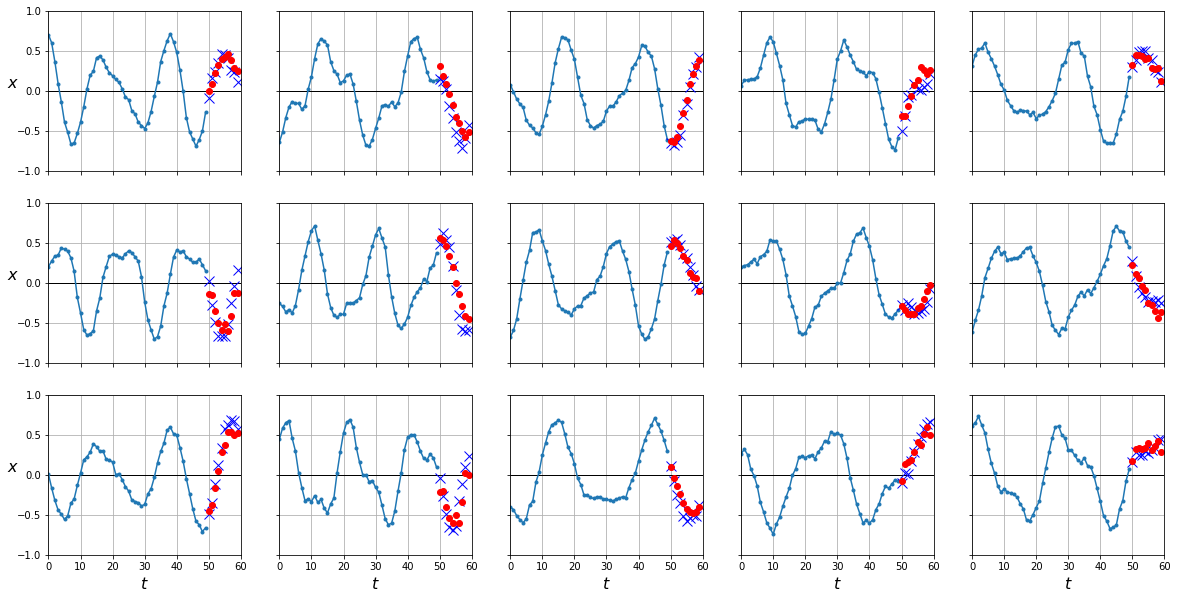

In [167]:
y_pred_10_outs_doble = predict(rnn_10_outs_doble, dataloader_10_outs['test'])
plot_series(X_test, y_test, y_pred_10_outs_doble.cpu().numpy())


### Vemos los resultados obtenidos y comparamos contra la red neuronal fully connected

In [168]:
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
mse_rnn_10_outs_doble =  mean_squared_error(np.squeeze(y_test), y_pred_10_outs_doble)
print("Error cuadratico medio de la estimación final: ",mse_rnn_10_outs_doble)

if mse_rnn_10_outs_doble < mse_mlp:
  print("Se mejoró el resultado!. De {} con NLP a {} con nuestra nueva RNN".format(mse_mlp,mse_rnn_10_outs_doble))
else:
  print("NO MEJORAMOS")  
print("Pamaetros: hiddens {} y layers {}".format(hidden_size_10_outs,layers_10_outs))

y_test shape:
(1000, 10, 1)
y_pred shape:
(1000, 10)
Error cuadratico medio de la estimación final:  0.013004321
Se mejoró el resultado!. De 0.018532823771238327 con NLP a 0.013004320673644543 con nuestra nueva RNN
Pamaetros: hiddens 40 y layers 4


## Resultados obtenidos

Partiendo de la red NLP que tuvo en test un MSE de 0.018532824

Obtuvimos resultados superiores con estas configuraciones:
* Con una red de 40 hiddens y 4 layers:  0.01300432
* Con una red de 50 hiddens y 3 layers:  0.01386837
* Con una red de 50 hiddens y 2 layers:  0.01485055
* Con una red de 30 hiddens y 4 layers:  0.01667059
* Con una red de 40 hiddens y 3 layers:  0.01694305
* Con una red de 40 hiddens y 2 layers:  0.01834031



Obtuvimos peores resultados con estas configuraciones:

* Con una red de 30 hidden y 3 layers:  0.01922401
* Con una red de 20 hidden y 4 layers:  0.02422239
